# Q1: Image Enhancement
## Autoencoder for MNIST Denoising

Autoencoders are neural networks designed to learn efficient data representations. They achieve this by compressing input data into a lower-dimensional space and then reconstructing it. In this project, we'll build and train an autoencoder to remove noise from handwritten digit images.

The process involves two main steps. First, the encoder compresses the input image. Then, the decoder attempts to reconstruct the original image from this compressed representation. By training on noisy images and comparing the output to clean originals, the autoencoder learns to distinguish between essential features and noise.

We'll use the MNIST dataset for this task. This dataset is widely used in machine learning and serves as an excellent starting point for image processing projects. Let's begin by implementing our autoencoder and exploring its denoising capabilities.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import struct
import os

In [13]:
# Set random seed for reproducibility
torch.manual_seed(3)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
num_epochs = 50
learning_rate = 0.001

## Data Preprocessing and Loading

Data preparation is a crucial step before training our autoencoder. This process involves several key components. First, we load the MNIST dataset, a standard collection of handwritten digits widely used in machine learning. Next, we apply normalization to the data. This step is essential for improving the model's performance and training stability.

The normalization process transforms the pixel values of the images. It adjusts them to have a mean of 0.1307 and a standard deviation of 0.3081. These specific values are derived from the statistics of the MNIST dataset (see [here](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457) or [here](https://stackoverflow.com/questions/63746182/correct-way-of-normalizing-and-scaling-the-mnist-dataset)). By normalizing the data, we ensure that all input features are on a similar scale. This standardization helps the model learn more effectively and converge faster during training.

Our data loading process utilizes custom dataset and dataloader classes. These classes efficiently handle the reading and processing of the MNIST files. They also apply the necessary transformations to prepare the data for input into our autoencoder model.

In [14]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

class MNISTDataset(Dataset):
    def __init__(self, images_file, labels_file, transform=None):
        self.images = self.read_idx_file(images_file)
        self.labels = self.read_idx_file(labels_file)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx].reshape(28, 28).astype(np.float32) / 255.0
        label = int(self.labels[idx])
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

    def read_idx_file(self, filename):
        with open(filename, 'rb') as f:
            zero, data_type, dims = struct.unpack('>HBB', f.read(4))
            shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
            return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)


In [15]:
# Get the current working directory
current_dir = os.getcwd()
# Get the parent directory, which is the root directory of the project
root_dir = os.path.dirname(current_dir)

# Construct absolute paths
train_images_path = os.path.join(root_dir, 'data', 'mnist', 'train-images.idx3-ubyte')
train_labels_path = os.path.join(root_dir, 'data', 'mnist', 'train-labels.idx1-ubyte')
test_images_path = os.path.join(root_dir, 'data', 'mnist', 't10k-images.idx3-ubyte')
test_labels_path = os.path.join(root_dir, 'data', 'mnist', 't10k-labels.idx1-ubyte')

In [16]:
# Create datasets
train_dataset = MNISTDataset(
    images_file=train_images_path,
    labels_file=train_labels_path,
    transform=transform
)

test_dataset = MNISTDataset(
    images_file=test_images_path,
    labels_file=test_labels_path,
    transform=transform
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

This preprocessing step sets the foundation for our autoencoder training. It ensures that our model receives consistent, well-prepared data, which is crucial for achieving optimal results in our image denoising task.

## Adding Noise to Images

To enhance the robustness of our autoencoder, we introduce artificial noise to the input images. This process serves two primary purposes:

1. It challenges the model to learn essential features amidst distortions.
2. It improves the model's generalization capabilities.

By training on noisy inputs, the autoencoder learns to differentiate between crucial image characteristics and random perturbations. This technique, often referred to as denoising, is a powerful method for unsupervised feature learning.

The noise addition function is implemented as follows:


In [17]:
# Add noise function
def add_noise(img):
    noise = torch.randn_like(img) * 0.1
    noisy_img = img + noise
    return noisy_img.clamp(0, 1)

This function adds Gaussian noise to the input image and clamps the resulting values to ensure they remain within the valid pixel range of [0, 1]. The standard deviation of 0.1 for the noise provides a balance between challenging the model and maintaining the image's core features.

## Building the Autoencoder

The core of our project is the autoencoder neural network. This architecture consists of two primary components:

1. The encoder: Compresses the input image into a lower-dimensional representation.
2. The decoder: Reconstructs the original image from the compressed representation.

The autoencoder's structure is implemented as follows:

In [18]:
# Autoencoder Model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder layers
        self.encode_conv1 = nn.Parameter(torch.randn(16, 1, 3, 3))
        self.encode_bias1 = nn.Parameter(torch.zeros(16))
        self.encode_conv2 = nn.Parameter(torch.randn(32, 16, 3, 3))
        self.encode_bias2 = nn.Parameter(torch.zeros(32))
        self.encode_conv3 = nn.Parameter(torch.randn(64, 32, 3, 3))
        self.encode_bias3 = nn.Parameter(torch.zeros(64))
        
        # Decoder layers
        self.decode_conv1 = nn.Parameter(torch.randn(64, 32, 3, 3))
        self.decode_bias1 = nn.Parameter(torch.zeros(32))
        self.decode_conv2 = nn.Parameter(torch.randn(32, 16, 3, 3))
        self.decode_bias2 = nn.Parameter(torch.zeros(16))
        self.decode_conv3 = nn.Parameter(torch.randn(16, 1, 3, 3))
        self.decode_bias3 = nn.Parameter(torch.zeros(1))

    def encode(self, x):
        x = F.relu(F.conv2d(x, weight=self.encode_conv1, bias=self.encode_bias1, padding=1))
        x = F.relu(F.conv2d(x, weight=self.encode_conv2, bias=self.encode_bias2, padding=1))
        x = F.relu(F.conv2d(x, weight=self.encode_conv3, bias=self.encode_bias3, padding=1))
        return x
    
    def decode(self, x):
        x = F.relu(F.conv_transpose2d(x, weight=self.decode_conv1, bias=self.decode_bias1, padding=1))
        x = F.relu(F.conv_transpose2d(x, weight=self.decode_conv2, bias=self.decode_bias2, padding=1))
        x = torch.sigmoid(F.conv_transpose2d(x, weight=self.decode_conv3, bias=self.decode_bias3, padding=1))
        return x
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

Key aspects of this implementation:

1. The encoder uses three convolutional layers with ReLU activation functions. Each layer increases the number of channels while maintaining spatial dimensions through padding.
2. The decoder mirrors the encoder's structure, using transposed convolutions to upsample the data. The final layer uses a sigmoid activation to ensure output values are between 0 and 1.
3. The forward method ties the encoding and decoding processes together, creating the full autoencoder pipeline.

This architecture allows the autoencoder to learn efficient representations of the input data, enabling it to denoise images effectively. The balance between the encoder and decoder is crucial for maintaining important features while removing noise.

## Training the Autoencoder

The training phase is a critical component of our autoencoder project. During this process, the model learns to effectively remove noise from images. The training procedure involves the following key steps:

1. We initialize the model, define the loss function (Mean Squared Error), and set up the optimizer (Adam) with our specified learning rate.
2. We feed noisy images through the autoencoder.
3. We compare the reconstructed outputs with the original, clean images.
4. Adjusting the model's parameters to minimize the difference between reconstructions and originals

We implement this process over multiple epochs, gradually refining the model's ability to denoise images. The training loop is structured as follows:


In [19]:
# Initialize model, loss, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        noisy_data = add_noise(data)
        
        optimizer.zero_grad()
        outputs = model(noisy_data)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            noisy_data = add_noise(data)
            outputs = model(noisy_data)
            loss = criterion(outputs, data)
            test_loss += loss.item()
    
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    # print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

This code iterates through the training data, performs forward and backward passes, and updates the model parameters. It also evaluates the model's performance on a separate test set to monitor for overfitting.

To visualize the training progress, we plot the training and test losses:

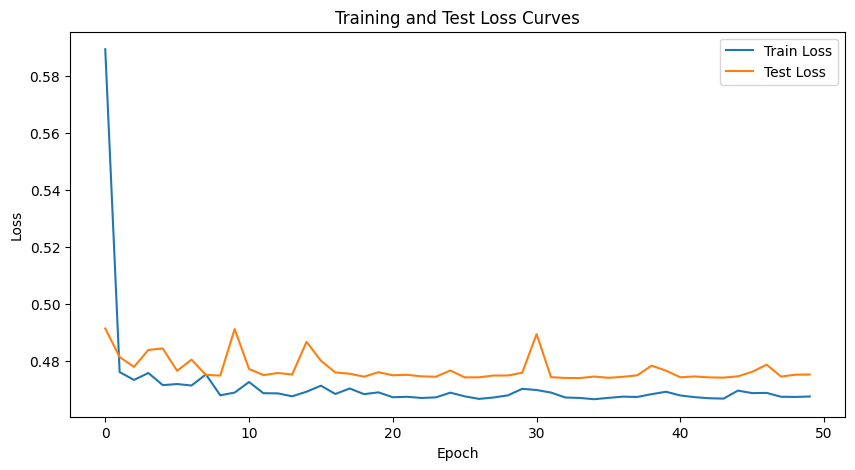

In [20]:
# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss Curves')
plt.show()

This visualization allows us to track the model's learning progress and identify any potential issues such as overfitting or underfitting.

By systematically exposing the autoencoder to noisy images and their clean counterparts, we enable it to learn robust representations that can effectively separate signal from noise in image data.


## Visualizing the Results

We now proceed to evaluate the performance of our trained autoencoder. This process involves three key steps:

1. Selecting a subset of test images
2. Adding artificial noise to these images
3. Passing the noisy images through our autoencoder for reconstruction

This evaluation allows us to visually assess the model's ability to denoise images effectively. We will display the original, noisy, and reconstructed images side by side for comparison.

The visualization process is implemented as follows:


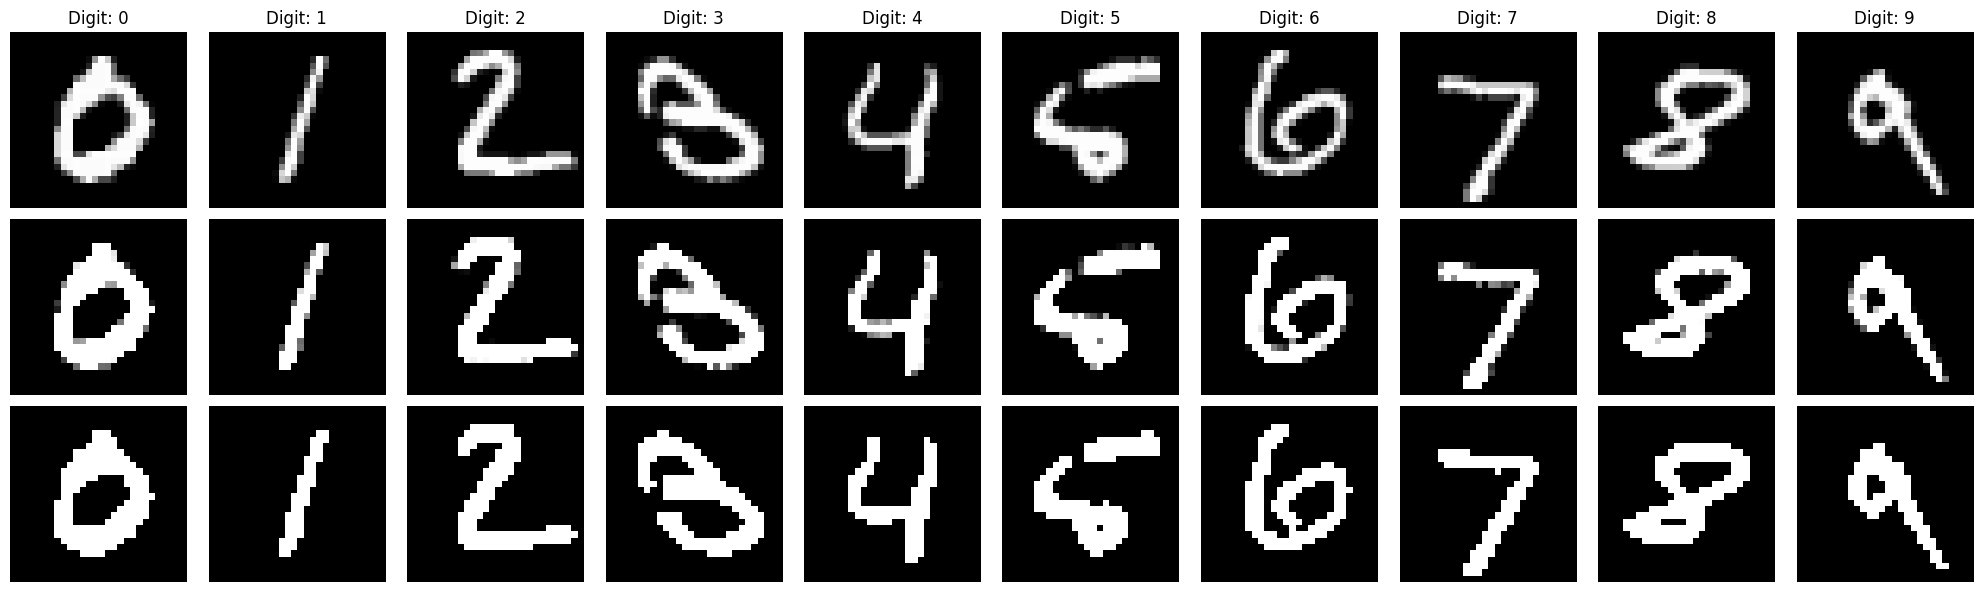

In [21]:
model.eval()
with torch.no_grad():
    # Find one example of each digit
    digits = {}
    for images, labels in test_loader:
        for image, label in zip(images, labels):
            if label.item() not in digits and len(digits) < 10:
                digits[label.item()] = image
        if len(digits) == 10:
            break
    
    # Sort the digits and create lists for processing
    test_images = torch.stack([digits[i] for i in range(10)]).to(device)
    noisy_images = add_noise(test_images)
    reconstructed = model(noisy_images)

    fig, axes = plt.subplots(3, 10, figsize=(20, 6))
    for i in range(10):
        axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Digit: {i}')
        axes[1, i].imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        axes[2, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        axes[2, i].axis('off')
    
    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Noisy')
    axes[2, 0].set_ylabel('Reconstructed')
    plt.tight_layout()
    plt.show()

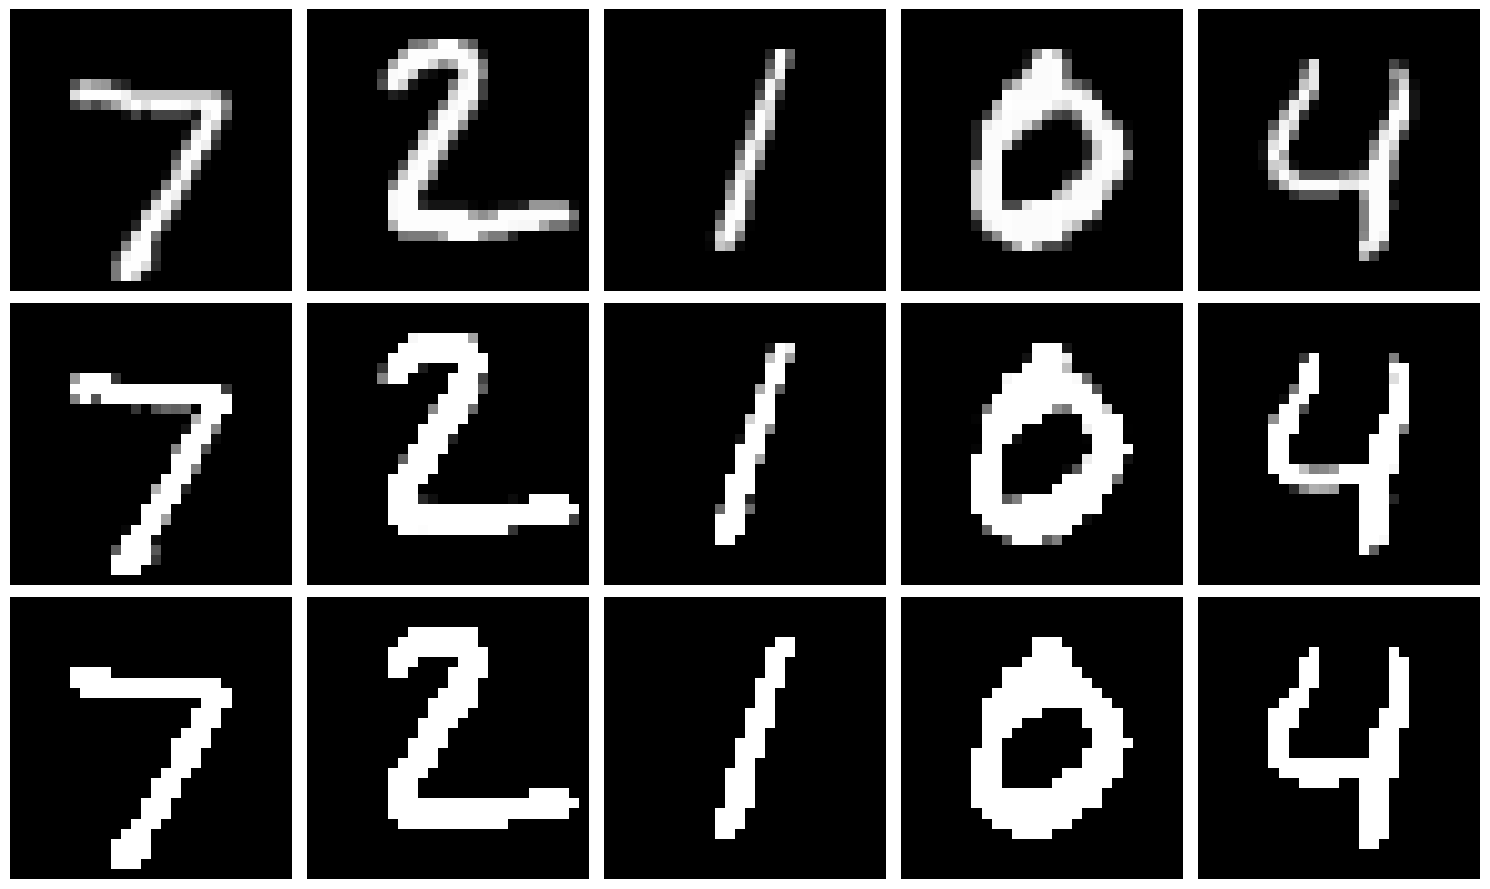

In [22]:
model.eval()
with torch.no_grad():
    test_images = next(iter(test_loader))[0][:5].to(device)
    noisy_images = add_noise(test_images)
    reconstructed = model(noisy_images)

    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for i in range(5):
        axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')
        axes[2, i].imshow(reconstructed[i].cpu().squeeze(), cmap='gray')
        axes[2, i].axis('off')
    
    axes[0, 0].set_ylabel('Original')
    axes[1, 0].set_ylabel('Noisy')
    axes[2, 0].set_ylabel('Reconstructed')
    plt.tight_layout()
    plt.show()

This code generates a figure with three rows:

1. Original test images
2. Noisy versions of these images
3. Reconstructed images produced by our autoencoder

By examining these results, we can gauge the effectiveness of our model in preserving essential features while removing noise. This visual comparison provides valuable insights into the autoencoder's performance and its potential applications in image denoising tasks.


## Save the model

In [11]:
# torch.save(model.state_dict(), 'autoencoder_model.pth')